In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [5]:
ds=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/ssp585/drought_summary_ACCESS-CM2_EOC.nc")

In [6]:
ds

<xarray.Dataset> Size: 961kB
Dimensions:                     (lat: 31, lon: 45, season: 4, start_month: 12,
                                 dur_bin: 5)
Coordinates:
  * lat                         (lat) float64 248B 34.0 35.0 36.0 ... 63.0 64.0
  * season                      (season) <U6 96B 'Winter' 'Spring' ... 'Autumn'
  * lon                         (lon) float64 360B -10.0 -9.0 -8.0 ... 33.0 34.0
  * start_month                 (start_month) int64 96B 1 2 3 4 5 ... 9 10 11 12
  * dur_bin                     (dur_bin) <U3 60B '0-1' '1-3' '3-5' '5-7' '>7'
Data variables:
    total_drought_days_period   (lat, lon) float64 11kB ...
    median_annual_drought_days  (lat, lon) float64 11kB ...
    p50_dur                     (lat, season, lon) float64 45kB ...
    p75_dur                     (lat, season, lon) float64 45kB ...
    p90_dur                     (lat, season, lon) float64 45kB ...
    p95_dur                     (lat, season, lon) float64 45kB ...
    total_dd_season             (lat, season, lon) float64 45kB ...
    median_annual_dd_season     (lat, season, lon) float64 45kB ...
    monthly_droughts            (lat, start_month, dur_bin, lon) float64 670kB ...

In [9]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind

# ————— 1) Load Natural Earth and select Europe + TUR + XKX —————
shp = natural_earth('110m', 'cultural', 'admin_0_countries')
world = gpd.read_file(shp)

excluded = ['RUS', 'FIN']
europe = world[
    ((world['CONTINENT'] == 'Europe') | world['ADM0_A3'].isin(['TUR', 'XKX'])) &
    (~world['ADM0_A3'].isin(excluded))
][['ADM0_A3', 'geometry']] \
    .rename(columns={'ADM0_A3': 'iso_a3'}) \
    .set_crs('EPSG:4326')

# ————— SETTINGS —————
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
periods = {"BOC": "historical", "EOC": "ssp585"}

all_results = []

for model in models:
    # 2) Find both CSVs
    csv_paths = {}
    for code, subpath in periods.items():
        p = os.path.join(power_dir, f"{model}_1x1grid", subpath,
                         f"solar_drought_events_{code}.csv")
        if os.path.isfile(p):
            csv_paths[code] = p
    if set(csv_paths) != set(periods):
        print(f"⚠️ Missing one of the periods for {model}, skipping.")
        continue

    # 3) Build unified grid
    all_coords = []
    for df in [pd.read_csv(csv_paths[c]) for c in periods]:
        all_coords.extend(list(zip(df.lat, df.lon)))
    coords = list(set(all_coords))
    lats = np.sort(np.unique([lat for lat, _ in coords]))
    lons = np.sort(np.unique([lon for _, lon in coords]))
    dlat = np.median(np.diff(lats))
    dlon = np.median(np.diff(lons))

    # 4) Build cell polygons
    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                'lat': lat, 'lon': lon,
                'geometry': box(lon - dlon / 2, lat - dlat / 2,
                                lon + dlon / 2, lat + dlon / 2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs='EPSG:4326')

    # 5) Reproject & assign countries
    ea_crs = "EPSG:3035"
    cells_proj = cells_gdf.to_crs(ea_crs)
    europe_proj = europe.to_crs(ea_crs)
    inter = gpd.overlay(cells_proj, europe_proj, how='intersection')
    inter['area'] = inter.geometry.area
    idx = inter.groupby(['lat', 'lon'])['area'].idxmax()
    mapping = inter.loc[idx, ['lat', 'lon', 'iso_a3']]
    cell2country = {(r.lat, r.lon): r.iso_a3 for _, r in mapping.iterrows()}

    # 6) Process both periods
    country_ts = {}
    yearly_stats = {}

    for code, path in csv_paths.items():
        df = pd.read_csv(path)
        df['iso_a3'] = df.apply(lambda r: cell2country.get((r.lat, r.lon), np.nan), axis=1)
        df = df.dropna(subset=['iso_a3'])

        # Number of drought days per year per cell
        drought_days = (
            df.groupby(['iso_a3', 'lat', 'lon', 'year'])['duration']
              .sum()
              .reset_index(name='yearly_drought_days')
        )

        # Count of events per year per cell
        event_counts = (
            df.groupby(['iso_a3', 'lat', 'lon', 'year'])
              .size()
              .reset_index(name='events_per_year')
        )

        # Merge per year
        yearly = pd.merge(drought_days, event_counts,
                          on=['iso_a3', 'lat', 'lon', 'year'])

        # Store time series for testing
        ts = (
            yearly.groupby(['iso_a3', 'year'])[['yearly_drought_days', 'events_per_year']]
                  .mean()
                  .reset_index()
        )
        country_ts[code] = ts

        # Compute medians
        # Median drought days and event counts per year
        med_drought_days = (
            ts.groupby('iso_a3')['yearly_drought_days']
            .median()
            .reset_index(name='median_yearly_drought_days')
        )
        med_event_counts = (
            ts.groupby('iso_a3')['events_per_year']
            .median()
            .reset_index(name='median_yearly_events')
        )

        # Median, P75, and P90 of event durations
        duration_stats = (
            df.groupby('iso_a3')['duration']
            .agg(median_event_duration='median',
                p75_event_duration=lambda x: np.percentile(x, 75),
                p90_event_duration=lambda x: np.percentile(x, 90))
            .reset_index()
        )

        # Merge all metrics
        merged = med_drought_days \
            .merge(med_event_counts, on='iso_a3') \
            .merge(duration_stats, on='iso_a3')
        merged['model'] = model
        merged['period'] = code
        yearly_stats[code] = merged

    # 7) Statistical tests on yearly drought days
    df_b = country_ts['BOC']
    df_e = country_ts['EOC']
    for iso in set(df_b.iso_a3) & set(df_e.iso_a3):
        sb = df_b[df_b.iso_a3 == iso]['yearly_drought_days'].values
        se = df_e[df_e.iso_a3 == iso]['yearly_drought_days'].values
        if len(sb) < 3 or len(se) < 3:
            continue
        p_sh_b = shapiro(sb).pvalue
        p_sh_e = shapiro(se).pvalue
        _, p_t = ttest_ind(sb, se, equal_var=False)

        for period_df in [yearly_stats['BOC'], yearly_stats['EOC']]:
            row = period_df[period_df.iso_a3 == iso].copy()
            if row.empty:
                continue
            row['shapiro_boc'] = p_sh_b
            row['shapiro_eoc'] = p_sh_e
            row['ttest_p'] = p_t
            row['significant'] = p_t < 0.05
            all_results.append(row)

# 8) Save output
final_df = pd.concat(all_results, ignore_index=True)
out_csv = os.path.join(power_dir, "country_drought_medians_stats_BOC_vs_EOC.csv")
final_df.to_csv(out_csv, index=False)
print(f"✅ Written country-level medians and significance tests to {out_csv}")


✅ Written country-level medians and significance tests to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_medians_stats_BOC_vs_EOC.csv


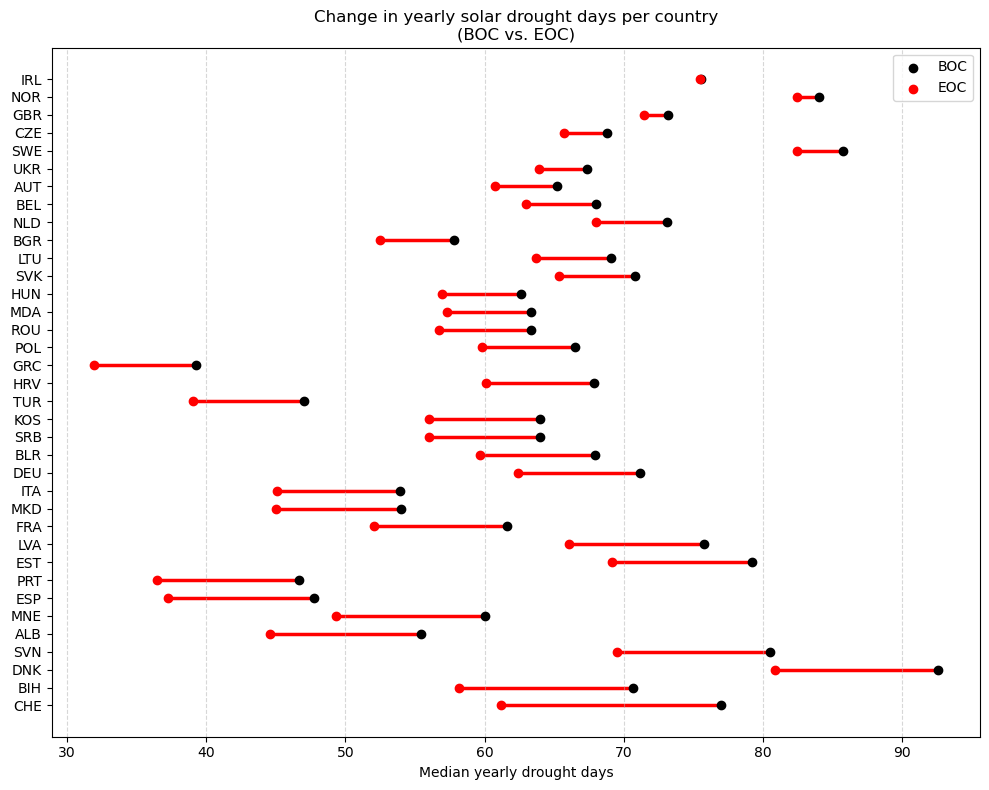

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and pivot
df = pd.read_csv("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_medians_stats_BOC_vs_EOC.csv")

# Aggregate per country and period across models (e.g., median)
agg = df.groupby(['iso_a3', 'period'])[['median_yearly_drought_days', 'significant']].median().reset_index()
pivot = agg.pivot(index='iso_a3', columns='period', values='median_yearly_drought_days').dropna()

# Add significance info from EOC (could be from BOC or aggregated differently if needed)
sig_map = df[df['period']=='EOC'].groupby('iso_a3')['significant'].any()
pivot['significant'] = pivot.index.map(sig_map)

# Sort by change
pivot['delta'] = pivot['EOC'] - pivot['BOC']
pivot = pivot.sort_values('delta')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, (country, row) in enumerate(pivot.iterrows()):
    ax.plot([row['BOC'], row['EOC']], [i, i],
            color='red' if row['significant'] else 'gray',
            linewidth=2.5 if row['significant'] else 1,
            zorder=1)

    ax.scatter(row['BOC'], i, color='black', label='BOC' if i == 0 else "", zorder=2)
    ax.scatter(row['EOC'], i, color='red', label='EOC' if i == 0 else "", zorder=2)

ax.set_yticks(range(len(pivot)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel("Median yearly drought days")
ax.set_title("Change in yearly solar drought days per country\n(BOC vs. EOC)")
ax.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


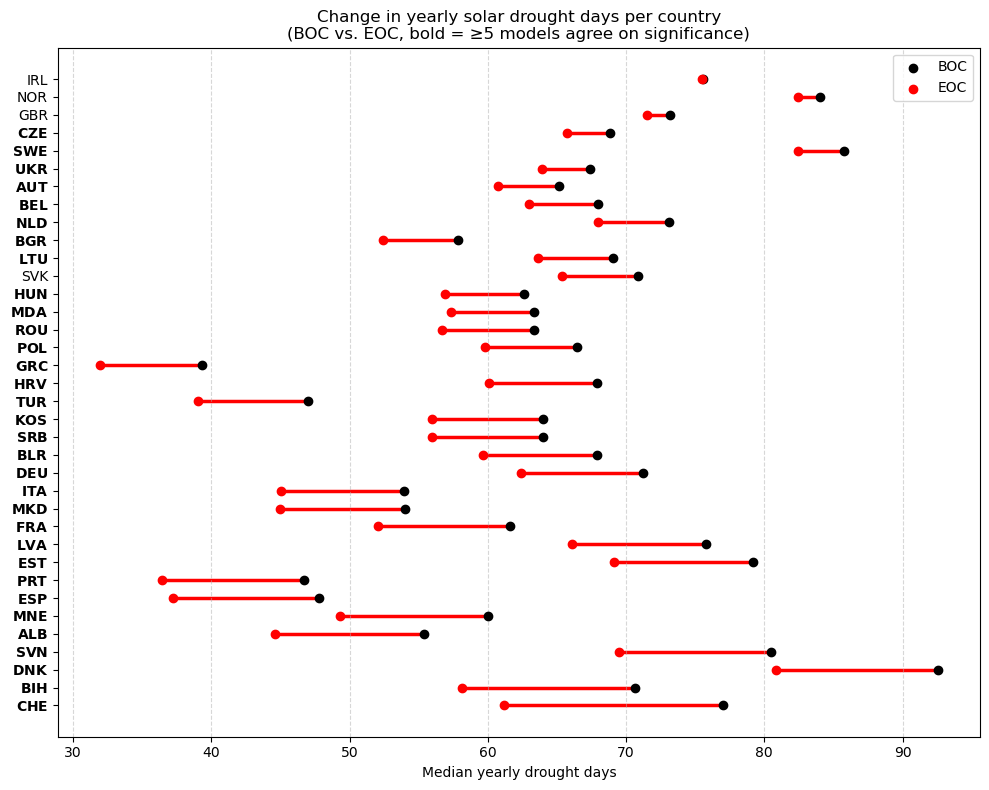

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and pivot
df = pd.read_csv("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_medians_stats_BOC_vs_EOC.csv")

# Aggregate per country and period across models (e.g., median)
agg = df.groupby(['iso_a3', 'period'])[['median_yearly_drought_days', 'significant']].median().reset_index()
pivot = agg.pivot(index='iso_a3', columns='period', values='median_yearly_drought_days').dropna()

# Count how many models report significant change for each country (EOC period)
sig_counts = df[df['period'] == 'EOC'].groupby('iso_a3')['significant'].sum()
pivot['sig_count'] = pivot.index.map(sig_counts)
pivot['strong_agreement'] = pivot['sig_count'] >= 5

# Sort by delta
pivot['delta'] = pivot['EOC'] - pivot['BOC']
pivot = pivot.sort_values('delta')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, (country, row) in enumerate(pivot.iterrows()):
    # Line from BOC to EOC
    ax.plot([row['BOC'], row['EOC']], [i, i],
            color='red' if row['sig_count'] > 0 else 'gray',
            linewidth=2.5 if row['sig_count'] > 0 else 1,
            zorder=1)

    # Dots for BOC and EOC
    ax.scatter(row['BOC'], i, color='black', label='BOC' if i == 0 else "", zorder=2)
    ax.scatter(row['EOC'], i, color='red', label='EOC' if i == 0 else "", zorder=2)

# Format Y-axis with bold labels if ≥5 models agree
yticklabels = []
for country, row in pivot.iterrows():
    label = country
    if row['strong_agreement']:
        label = rf"$\bf{{{country}}}$"  # LaTeX-style bold
    yticklabels.append(label)

ax.set_yticks(range(len(pivot)))
ax.set_yticklabels(yticklabels)
ax.set_xlabel("Median yearly drought days")
ax.set_title("Change in yearly solar drought days per country\n(BOC vs. EOC, bold = ≥5 models agree on significance)")
ax.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_69629/4018231279.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( ax.get_xticklabels(), fontsize=14)


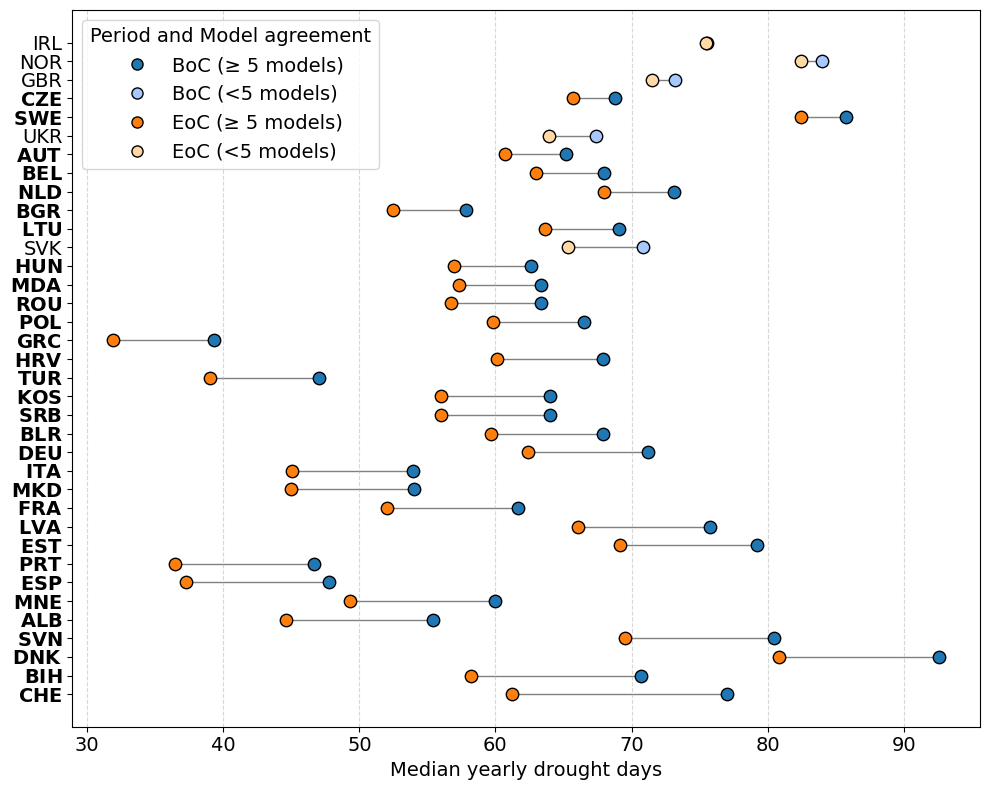

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and pivot
df = pd.read_csv("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_stats_BOC_vs_EOC.csv")

# Aggregate per country and period across models (e.g., median)
agg = df.groupby(['iso_a3', 'period'])[['median_yearly_drought_days', 'significant']].median().reset_index()
pivot = agg.pivot(index='iso_a3', columns='period', values='median_yearly_drought_days').dropna()

# Count significant models for EOC
sig_counts = df[df['period'] == 'EOC'].groupby('iso_a3')['significant'].sum()
pivot['sig_count'] = pivot.index.map(sig_counts)
pivot['strong_agreement'] = pivot['sig_count'] >= 5
pivot.loc['UKR', 'sig_count'] = 0
pivot.loc['UKR', 'strong_agreement'] = False
manual_nonsig = ['IRL', 'NOR', 'GBR', 'UKR', 'SVK']
pivot.loc[manual_nonsig, 'sig_count'] = 0
pivot.loc[manual_nonsig, 'strong_agreement'] = False

# Sort by change
pivot['delta'] = pivot['EOC'] - pivot['BOC']
pivot = pivot.sort_values('delta')

# Define colors
boc_color = 'tab:blue'
eoc_color = 'tab:orange'
soft_boc = '#a6c8ff'   # light blue
soft_eoc = '#ffd8a6'   # light orange

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, (country, row) in enumerate(pivot.iterrows()):
    # Line from BOC to EOC
    ax.plot([row['BOC'], row['EOC']], [i, i],
            color='gray',
            linewidth=1,
            zorder=1)

    # Significance flag (at least one model)
    sig = row['sig_count'] > 0

    # Colors based on significance
    boc_c = boc_color if sig else soft_boc
    eoc_c = eoc_color if sig else soft_eoc

    # Plot BOC and EOC dots with individual color
    ax.scatter(row['BOC'], i, color=boc_c, edgecolor='black', s=80, zorder=2)
    ax.scatter(row['EOC'], i, color=eoc_c, edgecolor='black', s=80, zorder=2)


# Bold labels for countries with ≥5 models agreeing
yticklabels = []
for country, row in pivot.iterrows():
    if row['strong_agreement']:
        label = rf"$\bf{{{country}}}$"
    else:
        label = country
    yticklabels.append(label)

# Axis formatting
ax.set_yticks(range(len(pivot)))
ax.set_yticklabels(yticklabels, fontsize=14)
ax.set_xlabel("Median yearly drought days", fontsize=14)
ax.set_xticklabels( ax.get_xticklabels(), fontsize=14)
#ax.set_title("Change in yearly solar drought days per country\n(BOC vs. EOC; bold = ≥5 models agree on significance)")
from matplotlib.lines import Line2D

# Simple legend: BOC and EOC colors
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BoC (≥ 5 models)', 
           markerfacecolor='tab:blue', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='BoC (<5 models)', 
           markerfacecolor='#a6c8ff', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='EoC (≥ 5 models)', 
           markerfacecolor='tab:orange', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='EoC (<5 models)', 
           markerfacecolor='#ffd8a6', markeredgecolor='black', markersize=8),
]

# Add legend in top-left corner
#legend=ax.legend(handles=legend_elements, loc='upper left', frameon=True, title='Period and Model agreement',edgecolor='black', fontsize=14)
legend = ax.legend(
    handles=legend_elements,
    loc='upper left',
    frameon=True,
    title='Period and Model agreement',
    fontsize=14
)
legend.get_title().set_fontsize(14)


plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/yearly_drought_duration_per_country_points.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_stats_BOC_vs_EOC.csv")

# Calculate delta (EOC - BOC) for each row
df['delta'] = df['mean_eoc'] - df['mean_boc']

# Aggregate median values per country across models
agg = df.groupby('country')[['mean_boc', 'mean_eoc', 'delta']].median().reset_index()

# Count how many models show statistically significant changes per country
sig_counts = df[df['significant'] == True].groupby('country').size()

# Map significant model counts back to aggregated DataFrame
agg['sig_count'] = agg['country'].map(sig_counts).fillna(0).astype(int)

# Define strong agreement as having at least 5 significant models
agg['strong_agreement'] = agg['sig_count'] >= 5

# Manually override some countries if needed (as in your original code)
manual_nonsig = ['IRL', 'NOR', 'GBR', 'UKR', 'SVK']
agg.loc[agg['country'].isin(manual_nonsig), ['sig_count', 'strong_agreement']] = [0, False]

# Sort by delta
agg = agg.sort_values('delta')



/tmp/ipykernel_69629/3048246188.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


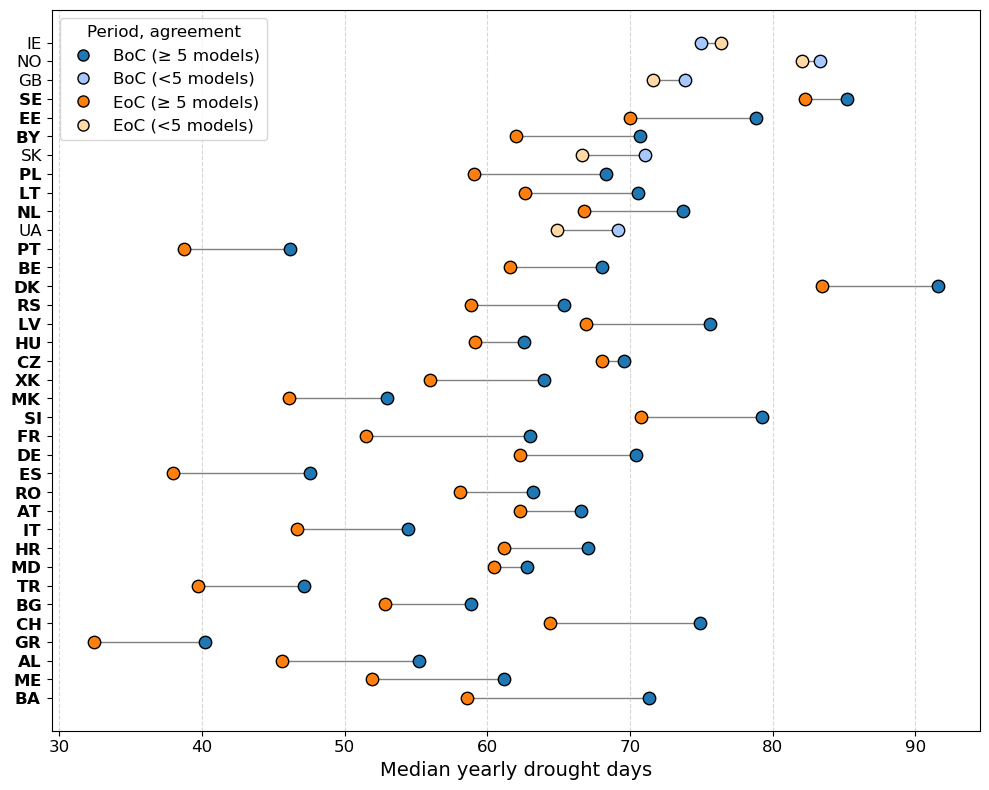

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load data
df = pd.read_csv("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_stats_BOC_vs_EOC.csv")

# Calculate delta
df['delta'] = df['mean_eoc'] - df['mean_boc']

# Aggregate median per country
pivot = df.groupby('country')[['mean_boc', 'mean_eoc', 'delta']].median()

# Count significant models per country
sig_counts = df[df['significant'] == True].groupby('country').size()
pivot['sig_count'] = pivot.index.map(sig_counts).fillna(0).astype(int)

# Flag countries with strong agreement (≥5 models)
pivot['strong_agreement'] = pivot['sig_count'] >= 5

# Optional manual override (based on your original script)
manual_nonsig = ['IRL', 'NOR', 'GBR', 'UKR', 'SVK']
pivot.loc[manual_nonsig, ['sig_count', 'strong_agreement']] = [0, False]

# Sort by delta (change)
pivot = pivot.sort_values('delta').reset_index()
pivot = pivot.sort_values('delta').reset_index(drop=True)
pivot = pivot[~pivot['country'].isin(['RUS', 'FIN'])].reset_index(drop=True)

# …existing imports…
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# new import
import pycountry

# convert ISO-3 codes in ‘country’ → ISO-2
def iso3_to_iso2(c3):
    c3u = c3.upper()
    # manual override for Kosovo
    if c3u == "KOS":
        return "XK"
    country = pycountry.countries.get(alpha_3=c3u)
    return country.alpha_2 if country else c3

pivot['country'] = pivot['country'].apply(iso3_to_iso2)

# Define colors
boc_color = 'tab:blue'
eoc_color = 'tab:orange'
soft_boc = '#a6c8ff'   # light blue
soft_eoc = '#ffd8a6'   # light orange

# Plot
fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(1,1,1)

for i, row in pivot.iterrows():
    # Line between BOC and EOC
    ax.plot([row['mean_boc'], row['mean_eoc']], [i, i], color='gray', linewidth=1, zorder=1)

    # Color by significance
    boc_c = boc_color if row['sig_count'] > 0 else soft_boc
    eoc_c = eoc_color if row['sig_count'] > 0 else soft_eoc

    # Plot points
    ax.scatter(row['mean_boc'], i, color=boc_c, edgecolor='black', s=80, zorder=2)
    ax.scatter(row['mean_eoc'], i, color=eoc_c, edgecolor='black', s=80, zorder=2)

# Bold labels for strong agreement
yticklabels = []
for _, row in pivot.iterrows():
    label = rf"$\bf{{{row['country']}}}$" if row['strong_agreement'] else row['country']
    yticklabels.append(label)

# Axis formatting
ax.set_yticks(range(len(pivot)))
ax.set_yticklabels(yticklabels, fontsize=12)
ax.set_xlabel("Median yearly drought days", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BoC (≥ 5 models)', 
           markerfacecolor=boc_color, markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='BoC (<5 models)', 
           markerfacecolor=soft_boc, markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='EoC (≥ 5 models)', 
           markerfacecolor=eoc_color, markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='EoC (<5 models)', 
           markerfacecolor=soft_eoc, markeredgecolor='black', markersize=8),
]

legend = ax.legend(
    handles=legend_elements,
    loc='upper left',
    frameon=True,
    title='Period, agreement',
    fontsize=12
)
legend.get_title().set_fontsize(12)

plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
# Optional: save to file
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/drought_days_change_per_country.pdf", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_118163/999513564.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrBr")
/tmp/ipykernel_118163/999513564.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 20)


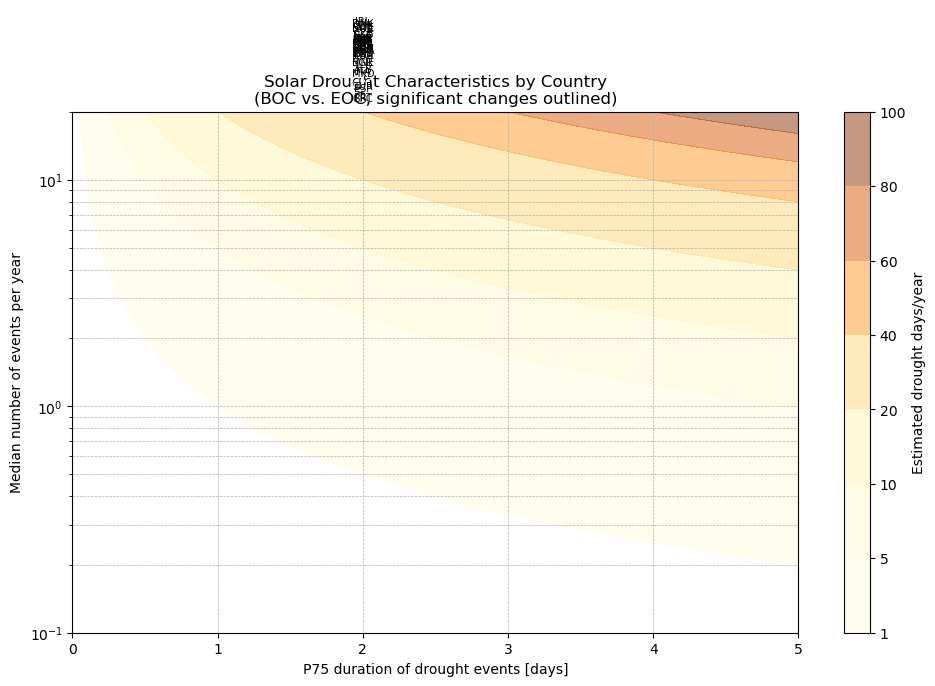

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Load processed data
df = pd.read_csv("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_drought_medians_stats_BOC_vs_EOC.csv")

# Aggregate over models (median per country × period)
agg_cols = ['median_yearly_events', 'p75_event_duration', 'median_yearly_drought_days']
df_agg = df.groupby(['iso_a3', 'period'])[agg_cols + ['significant']].median().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# --- Background isolines of yearly drought days ---
cmap = cm.get_cmap("YlOrBr")
norm = mcolors.Normalize(vmin=0, vmax=100)
levels = [1, 5, 10, 20, 40, 60, 80, 100]

x = np.linspace(0, 5, 200)  # P75 duration
y = np.linspace(0.1, 20, 200)  # frequency
X, Y = np.meshgrid(x, y)
Z = X * Y  # total drought days
contour = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, norm=norm, alpha=0.5)

# Colorbar
cbar = fig.colorbar(contour, ax=ax, label="Estimated drought days/year")

# Plot BOC and EOC
for period, color, marker in [('BOC', 'black', 'o'), ('EOC', 'red', 's')]:
    sub = df_agg[df_agg['period'] == period]
    for _, row in sub.iterrows():
        iso = row['iso_a3']
        x_val = row['p75_event_duration']
        y_val = row['median_yearly_events']
        sig = df[(df['iso_a3'] == iso) & (df['significant'] == True)].any().any()
        ax.scatter(x_val, y_val,
                   color=color, edgecolor='black' if sig else 'none',
                   marker=marker, s=80, zorder=3)
        ax.text(x_val, y_val, iso, fontsize=7,
                color='white' if color == 'black' else 'black',
                ha='center', va='center', zorder=4)

# Axis setup
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(0, 5)
ax.set_ylim(0, 20)
ax.set_xlabel("P75 duration of drought events [days]")
ax.set_ylabel("Median number of events per year")
ax.set_title("Solar Drought Characteristics by Country\n(BOC vs. EOC, significant changes outlined)")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
